<a href="https://colab.research.google.com/github/Satvik256/Graph-Convolutional-Networks/blob/main/GCN_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install stellargraph

     |████████████████████████████████| 440kB 22.5MB/s 


In [ ]:
pip install spectral-libraries

     |████████████████████████████████| 931kB 14.0MB/s 
  Created wheel for spectral-libraries: filename=spectral_libraries-1.0.9-cp36-none-any.whl size=1197274 sha256=e95f4877db35d43254cde1f9f87a4df397291a796fff594e8a4b3d8dc8514b98
  Stored in directory: /root/.cache/pip/wheels/63/d2/15/129609fb04caaa85391ff627425e44276278061ba3f26fe18d
Successfully built spectral-libraries


In [ ]:
pip install spektral

     |████████████████████████████████| 102kB 8.1MB/s 


In [ ]:
import numpy as np
import os
import networkx as nx
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
from sklearn.metrics import classification_report

from spektral.layers import GraphConv

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dropout, Dense
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
import tensorflow as tf
from tensorflow.keras.regularizers import l2

from collections import Counter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [ ]:
import stellargraph as sg
import pandas as pd
import os
from stellargraph.mapper import FullBatchNodeGenerator
from stellargraph.layer import GCN
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt

##***CORA DATASET***
we have machine learning papers from seven different areas and want to classify which paper belongs to which. The features of each paper are often occurring words. An edge between two nodes shows that one paper cites the other one. By looking at the dataset we can already see that papers of the same area form a cluster.
CORA citation network dataset consists of 2708 nodes, where each node represents a document or a technical paper. The node features are bag-of-words representation that indicates the presence of a word in the document. The vocabulary — hence, also the node features — contains 1433 words.
We will treat the dataset as an **directed graph** where the edge represents whether one document cites the other or vice versa
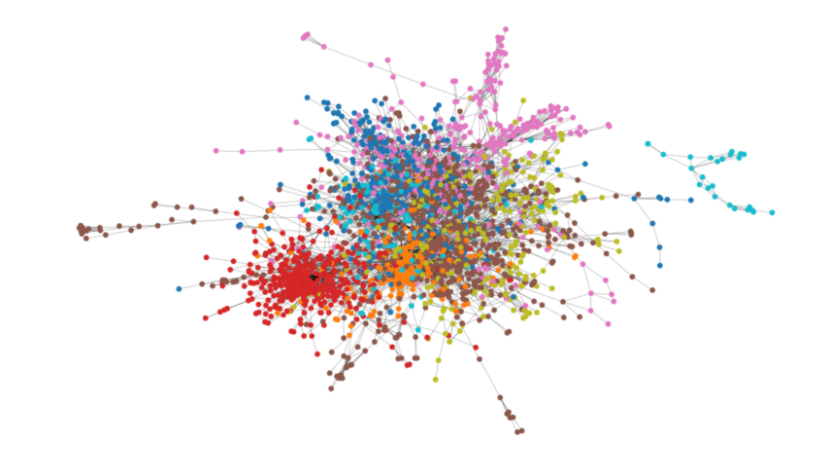

In [ ]:
all_data = []
all_edges = []

for root,dirs,files in os.walk('./cora'):
    for file in files:
        if '.content' in file:
            with open(os.path.join(root,file),'r') as f:
                all_data.extend(f.read().splitlines())
        elif 'cites' in file:
            with open(os.path.join(root,file),'r') as f:
                all_edges.extend(f.read().splitlines())

              
random_state = 77
all_data = shuffle(all_data,random_state=random_state)

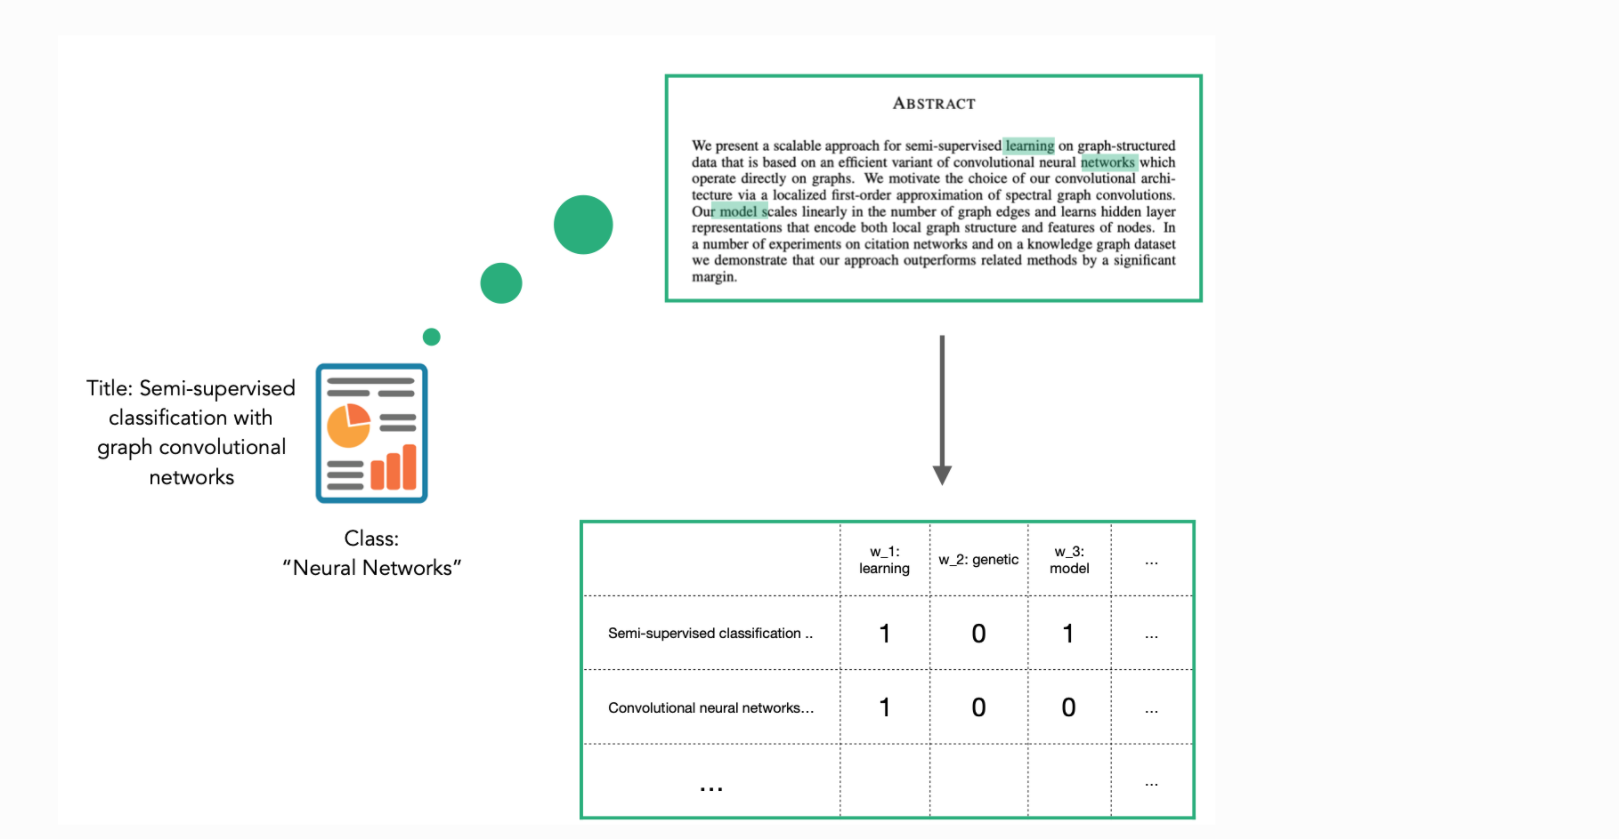

In [ ]:
labels = []
nodes = []
X = []

for i,data in enumerate(all_data):
    elements = data.split('\t')
    labels.append(elements[-1])
    X.append(elements[1:-1])
    nodes.append(elements[0])

X = np.array(X,dtype=int)
N = X.shape[0] #number of nodes
F = X.shape[1] #size of node features
print('X shape: ', X.shape)


edge_list=[]
for edge in all_edges:
    e = edge.split('\t')
    edge_list.append((e[0],e[1]))

print('\nNumber of nodes (N): ', N)
print('\nNumber of features (F) of each node: ', F)
print('\nCategories: ', set(labels))

num_classes = len(set(labels))
print('\nNumber of classes: ', num_classes)

X shape:  (2708, 1433)

Number of nodes (N):  2708

Number of features (F) of each node:  1433

Categories:  {'Theory', 'Rule_Learning', 'Reinforcement_Learning', 'Case_Based', 'Neural_Networks', 'Probabilistic_Methods', 'Genetic_Algorithms'}

Number of classes:  7


In [ ]:
def limit_data(labels,limit=20,val_num=500,test_num=1000):

    label_counter = dict((l, 0) for l in labels)
    train_idx = []

    for i in range(len(labels)):
        label = labels[i]
        if label_counter[label]<limit:
            train_idx.append(i)
            label_counter[label]+=1
      
        if all(count == limit for count in label_counter.values()):
            break
    
    rest_idx = [x for x in range(len(labels)) if x not in train_idx]

    val_idx = rest_idx[:val_num]
    test_idx = rest_idx[val_num:(val_num+test_num)]
    return train_idx, val_idx,test_idx

train_idx,val_idx,test_idx = limit_data(labels)

In [ ]:
#Masking
train_mask = np.zeros((N,),dtype=bool)
train_mask[train_idx] = True

val_mask = np.zeros((N,),dtype=bool)
val_mask[val_idx] = True

test_mask = np.zeros((N,),dtype=bool)
test_mask[test_idx] = True

In [ ]:
print("All Data Distribution: \n{}".format(Counter(labels)))

All Data Distribution: 
Counter({'Neural_Networks': 818, 'Probabilistic_Methods': 426, 'Genetic_Algorithms': 418, 'Theory': 351, 'Case_Based': 298, 'Reinforcement_Learning': 217, 'Rule_Learning': 180})


In [ ]:
print("Training Data Distribution: \n{}".format(Counter([labels[i] for i in train_idx])))

Training Data Distribution: 
Counter({'Reinforcement_Learning': 20, 'Probabilistic_Methods': 20, 'Neural_Networks': 20, 'Case_Based': 20, 'Theory': 20, 'Genetic_Algorithms': 20, 'Rule_Learning': 20})


In [ ]:
print("Validation Data Distribution: \n{}".format(Counter([labels[i] for i in val_idx])))

Validation Data Distribution: 
Counter({'Neural_Networks': 172, 'Genetic_Algorithms': 78, 'Probabilistic_Methods': 72, 'Theory': 63, 'Case_Based': 58, 'Reinforcement_Learning': 35, 'Rule_Learning': 22})


In [ ]:
#build the graph
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edge_list)

#obtain the adjacency matrix (A)
A = nx.adjacency_matrix(G)
print('Graph info: ', nx.info(G))

Graph info:  Name: 
Type: Graph
Number of nodes: 2708
Number of edges: 5278
Average degree:   3.8981


In [ ]:
def encode_label(labels):
    label_encoder = LabelEncoder()
    labels = label_encoder.fit_transform(labels)
    labels = to_categorical(labels)
    return labels, label_encoder.classes_

labels_encoded, classes = encode_label(labels)

In [ ]:
# Parameters
channels = 16           # Number of channels in the first layer
dropout = 0.5           # Dropout rate for the features
l2_reg = 5e-4           # L2 regularization rate
learning_rate = 1e-2    # Learning rate
epochs = 200            # Number of training epochs
es_patience = 10        # Patience for early stopping

A = GraphConv.preprocess(A).astype('f4')

X_in = Input(shape=(F, ))
fltr_in = Input((N, ), sparse=True)

dropout_1 = Dropout(dropout)(X_in)
graph_conv_1 = GraphConv(channels,
                         activation='relu',
                         kernel_regularizer=l2(l2_reg),
                         use_bias=False)([dropout_1, fltr_in])

dropout_2 = Dropout(dropout)(graph_conv_1)
graph_conv_2 = GraphConv(num_classes,
                         activation='softmax',
                         use_bias=False)([dropout_2, fltr_in])

# Build model
model = Model(inputs=[X_in, fltr_in], outputs=graph_conv_2)
optimizer = Adam(lr=learning_rate)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              weighted_metrics=['acc'])
model.summary()

tbCallBack_GCN = tf.keras.callbacks.TensorBoard(
    log_dir='./Tensorboard_GCN_cora',
)
callback_GCN = [tbCallBack_GCN]

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1433)]       0                                            
__________________________________________________________________________________________________
dropout (Dropout)               (None, 1433)         0           input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 2708)]       0                                            
__________________________________________________________________________________________________
graph_conv (GraphConv)          (None, 16)           22928       dropout[0][0]                    
                                                                 input_2[0][0]         

In [ ]:
# Train model
validation_data = ([X, A], labels_encoded, val_mask)
model.fit([X, A],
          labels_encoded,
          sample_weight=train_mask,
          epochs=epochs,
          batch_size=N,
          validation_data=validation_data,
          shuffle=False,
          callbacks=[
              EarlyStopping(patience=es_patience,  restore_best_weights=True),
              tbCallBack_GCN
          ])

Epoch 1/200
1/1 [==============================] - 1s 542ms/step - loss: 0.1165 - acc: 0.1714 - val_loss: 0.3644 - val_acc: 0.2580
Epoch 2/200
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1/1 [==============================] - 0s 72ms/step - loss: 0.1101 - acc: 0.2857 - val_loss: 0.3543 - val_acc: 0.3140
Epoch 3/200
1/1 [==============================] - 0s 79ms/step - loss: 0.1023 - acc: 0.4000 - val_loss: 0.3434 - val_acc: 0.3380
Epoch 4/200
1/1 [==============================] - 0s 71ms/step - loss: 0.0967 - acc: 0.4714 - val_loss: 0.3328 - val_acc: 0.3460
Epoch 5/200
1/1 [==============================] - 0s 73ms/step - loss: 0.0908 - acc: 0.5071 - val_loss: 0.3227 - val_acc: 0.3660
Epoch 6/200
1/1 [==============================] - 0s 73ms/step - loss: 0.0858 - acc: 0.5857 - val_loss: 0.3132 - val_acc: 0.3960
Epoch 7/200
1/1 [==============================] - 0s 70ms/step - loss: 0.0826 - acc: 0.5643 - val_loss: 0.3050 - val_acc: 0.4220
Epoch 8/200
1/1 [

In [ ]:
X_te = X[test_mask]
A_te = A[test_mask,:][:,test_mask]
y_te = labels_encoded[test_mask]

y_pred = model.predict([X_te, A_te], batch_size=N)
report = classification_report(np.argmax(y_te,axis=1), np.argmax(y_pred,axis=1), target_names=classes)
print('GCN Classification Report: \n {}'.format(report))

GCN Classification Report: 
                         precision    recall  f1-score   support

            Case_Based       0.68      0.82      0.74       114
    Genetic_Algorithms       0.85      0.88      0.86       156
       Neural_Networks       0.80      0.68      0.73       290
 Probabilistic_Methods       0.78      0.70      0.74       172
Reinforcement_Learning       0.75      0.73      0.74        85
         Rule_Learning       0.57      0.77      0.65        60
                Theory       0.59      0.66      0.62       123

              accuracy                           0.73      1000
             macro avg       0.72      0.75      0.73      1000
          weighted avg       0.75      0.73      0.74      1000



In [ ]:
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict([X,A],batch_size=N)

#Get t-SNE Representation
#get the hidden layer representation after the first GCN layer
x_tsne = TSNE(n_components=2).fit_transform(activations[3])

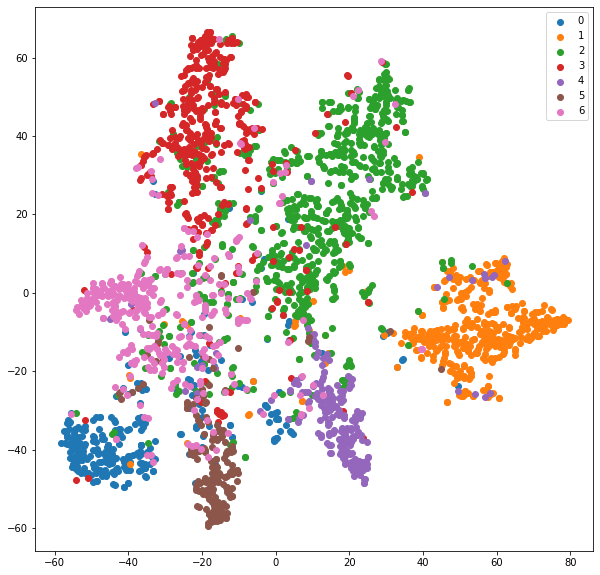

In [ ]:
def plot_tSNE(labels_encoded,x_tsne):
    color_map = np.argmax(labels_encoded, axis=1)
    plt.figure(figsize=(10,10))
    for cl in range(num_classes):
        indices = np.where(color_map==cl)
        indices = indices[0]
        plt.scatter(x_tsne[indices,0], x_tsne[indices, 1], label=cl)
    plt.legend()
    plt.show()
    
plot_tSNE(labels_encoded,x_tsne)

##**COMPARING THE GCN MODEL WITH A FULLY CONNECTED NEURAL NETWORK**
###As a benchmark, We also trained a 2-layer Fully Connected Neural Networks (FCNN) and plot the t-SNE visualization of hidden layer representations.
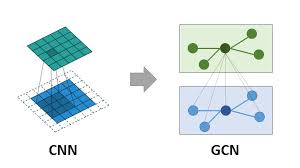


In [ ]:
es_patience = 10
optimizer = Adam(lr=1e-2)
l2_reg = 5e-4
epochs = 200

#Compare with FNN

model_fnn = Sequential()
model_fnn.add(Dense(
                    128,
                    input_dim=X.shape[1],
                    activation=tf.nn.relu,
                    kernel_regularizer=tf.keras.regularizers.l2(l2_reg))
             )
model_fnn.add(Dropout(0.5))
model_fnn.add(Dense(256, activation=tf.nn.relu))
model_fnn.add(Dropout(0.5))
model_fnn.add(Dense(num_classes, activation=tf.keras.activations.softmax))


model_fnn.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              weighted_metrics=['acc'])



tbCallBack_FNN = TensorBoard(
    log_dir='./Tensorboard_FNN_cora',
)


validation_data_fnn = (X, labels_encoded, val_mask)
model_fnn.fit(
                X,labels_encoded,
                sample_weight=train_mask,
                epochs=epochs,
                batch_size=N,
                validation_data=validation_data_fnn,
                shuffle=False,
                callbacks=[
                  EarlyStopping(patience=es_patience,  restore_best_weights=True),
                  tbCallBack_FNN
          ])

Epoch 1/200
1/1 [==============================] - 0s 368ms/step - loss: 0.2194 - acc: 0.1500 - val_loss: 0.4339 - val_acc: 0.3000
Epoch 2/200
1/1 [==============================] - 0s 33ms/step - loss: 0.1759 - acc: 0.3714 - val_loss: 0.4023 - val_acc: 0.4000
Epoch 3/200
1/1 [==============================] - 0s 33ms/step - loss: 0.1426 - acc: 0.5071 - val_loss: 0.3739 - val_acc: 0.4520
Epoch 4/200
1/1 [==============================] - 0s 32ms/step - loss: 0.1145 - acc: 0.7000 - val_loss: 0.3430 - val_acc: 0.5220
Epoch 5/200
1/1 [==============================] - 0s 34ms/step - loss: 0.0904 - acc: 0.8071 - val_loss: 0.3075 - val_acc: 0.5800
Epoch 6/200
1/1 [==============================] - 0s 38ms/step - loss: 0.0666 - acc: 0.9000 - val_loss: 0.2793 - val_acc: 0.5900
Epoch 7/200
1/1 [==============================] - 0s 33ms/step - loss: 0.0541 - acc: 0.9071 - val_loss: 0.2590 - val_acc: 0.5960
Epoch 8/200
1/1 [==============================] - 0s 32ms/step - loss: 0.0474 - acc: 0.9

In [ ]:
y_pred = model_fnn.predict(X_te)
report = classification_report(np.argmax(y_te,axis=1), np.argmax(y_pred,axis=1), target_names=classes)
print('FCNN Classification Report: \n {}'.format(report))

FCNN Classification Report: 
                         precision    recall  f1-score   support

            Case_Based       0.54      0.58      0.56       114
    Genetic_Algorithms       0.66      0.85      0.74       156
       Neural_Networks       0.75      0.49      0.60       290
 Probabilistic_Methods       0.64      0.57      0.60       172
Reinforcement_Learning       0.47      0.56      0.51        85
         Rule_Learning       0.49      0.60      0.54        60
                Theory       0.37      0.48      0.42       123

              accuracy                           0.58      1000
             macro avg       0.56      0.59      0.57      1000
          weighted avg       0.61      0.58      0.58      1000



In [ ]:
layer_outputs = [layer.output for layer in model_fnn.layers] 
activation_model = Model(inputs=model_fnn.input, outputs=layer_outputs)
activations = activation_model.predict([X])

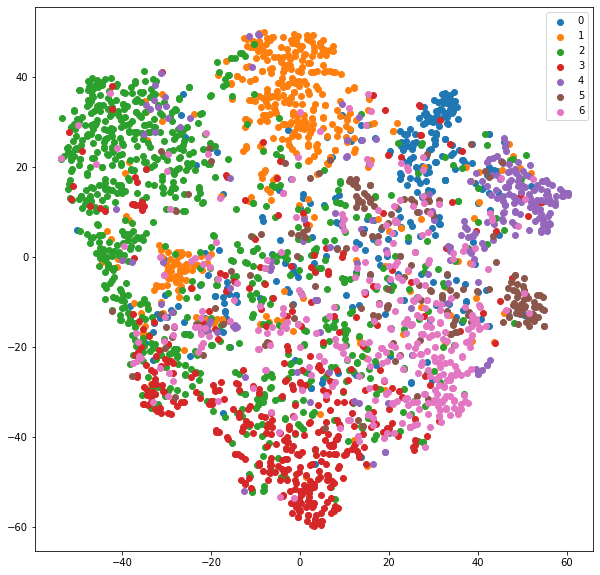

In [ ]:
x_tsne = TSNE(n_components=2).fit_transform(activations[3])
plot_tSNE(labels_encoded,x_tsne)

####**From the results above, it is clear that GCN significantly outperforms FCNN with macro average F1-score is only 55%. The t-SNE visualization plot of FCNN hidden layer representations is scattered, which means that FCNN can’t learn the features representations as well as GCN.**
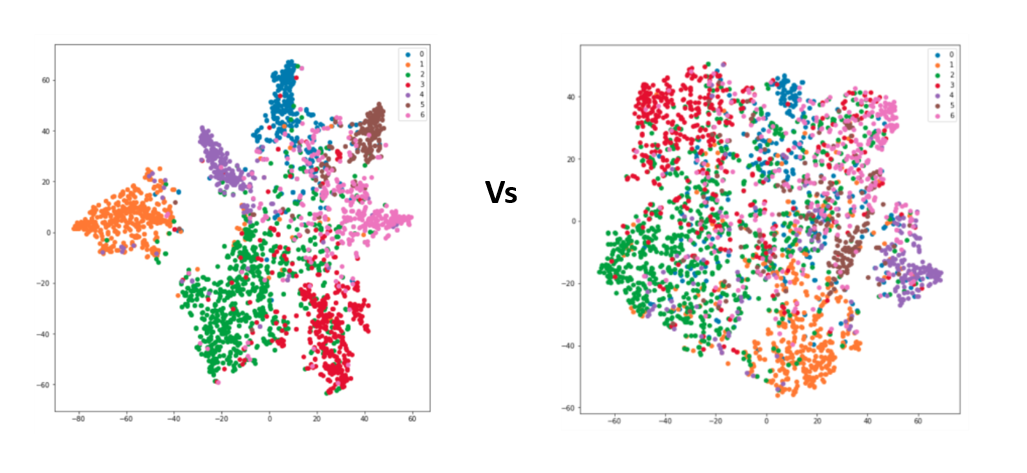

#PubMed Dataset Results

In [ ]:
dataset = sg.datasets.PubMedDiabetes() 
display(HTML(dataset.description))
G, node_subjects = dataset.load()

In [ ]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 19717, Edges: 44338

 Node types:
  paper: [19717]
    Features: float32 vector, length 500
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [44338]
        Weights: all 1 (default)
        Features: none


In [ ]:
print(node_subjects.value_counts().to_frame())

   label
2   7875
3   7739
1   4103


In [ ]:
train_subjects, test_subjects = model_selection.train_test_split(node_subjects,train_size=250, test_size=None, stratify=node_subjects)
val_subjects, test_subjects = model_selection.train_test_split(test_subjects,train_size=750, test_size=None, stratify=test_subjects)
train_subjects.value_counts().to_frame()

,label
2,100
3,98
1,52


In [ ]:
target_encoding = preprocessing.LabelBinarizer()
train_targets = target_encoding.fit_transform(train_subjects)
val_targets = target_encoding.transform(val_subjects)
test_targets = target_encoding.transform(test_subjects)

In [ ]:
generator = FullBatchNodeGenerator(G, method="gcn")
train_gen = generator.flow(train_subjects.index, train_targets)

Using GCN (local pooling) filters...


In [ ]:
gcn = GCN(layer_sizes=[30,30], activations=["relu", "relu"], generator=generator, dropout=0.15)

In [ ]:
x_inp, x_out = gcn.in_out_tensors()
print(x_out)

Tensor("gather_indices_2/GatherV2:0", shape=(1, None, 30), dtype=float32)


In [ ]:
predictions = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

In [ ]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(lr=0.01),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

In [ ]:
val_gen = generator.flow(val_subjects.index, val_targets)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
es_callback = EarlyStopping(monitor="val_acc", patience=60, restore_best_weights=True)

In [ ]:
history = model.fit(
    train_gen,
    epochs=200,
    validation_data=val_gen,
    verbose=2,
    shuffle=False, 
    callbacks=[es_callback])

Epoch 1/200
1/1 - 0s - loss: 1.0985 - acc: 0.3000 - val_loss: 1.0853 - val_acc: 0.5280
Epoch 2/200
1/1 - 0s - loss: 1.0839 - acc: 0.5200 - val_loss: 1.0686 - val_acc: 0.5613
Epoch 3/200
1/1 - 0s - loss: 1.0641 - acc: 0.5880 - val_loss: 1.0493 - val_acc: 0.5893
Epoch 4/200
1/1 - 0s - loss: 1.0416 - acc: 0.6240 - val_loss: 1.0287 - val_acc: 0.6067
Epoch 5/200
1/1 - 0s - loss: 1.0176 - acc: 0.6320 - val_loss: 1.0072 - val_acc: 0.6013
Epoch 6/200
1/1 - 0s - loss: 0.9911 - acc: 0.6480 - val_loss: 0.9847 - val_acc: 0.6067
Epoch 7/200
1/1 - 0s - loss: 0.9615 - acc: 0.6600 - val_loss: 0.9611 - val_acc: 0.6093
Epoch 8/200
1/1 - 0s - loss: 0.9328 - acc: 0.6480 - val_loss: 0.9367 - val_acc: 0.6067
Epoch 9/200
1/1 - 0s - loss: 0.9021 - acc: 0.6520 - val_loss: 0.9108 - val_acc: 0.6093
Epoch 10/200
1/1 - 0s - loss: 0.8647 - acc: 0.6560 - val_loss: 0.8825 - val_acc: 0.6107
Epoch 11/200
1/1 - 0s - loss: 0.8334 - acc: 0.6600 - val_loss: 0.8517 - val_acc: 0.6147
Epoch 12/200
1/1 - 0s - loss: 0.7913 - ac

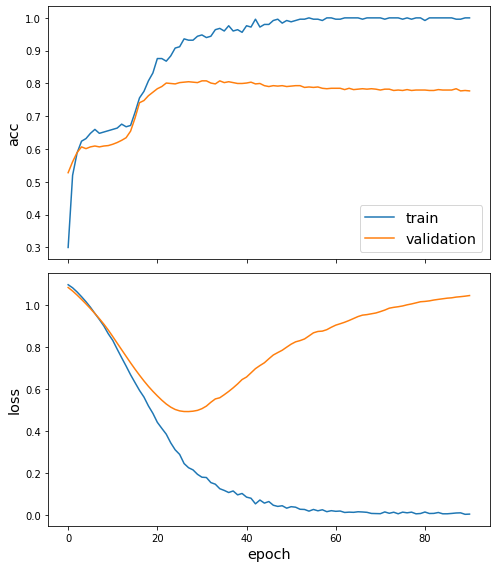

In [ ]:
sg.utils.plot_history(history)

In [ ]:
test_gen = generator.flow(test_subjects.index, test_targets)
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 2ms/step - loss: 0.4878 - acc: 0.8245

Test Set Metrics:
	loss: 0.4878
	acc: 0.8245


In [ ]:
all_nodes = node_subjects.index
all_gen = generator.flow(all_nodes)
all_predictions = model.predict(all_gen)
node_predictions = target_encoding.inverse_transform(all_predictions.squeeze())

df = pd.DataFrame({"Predicted": node_predictions, "True": node_subjects})
print(df.head(20))
# df.to_csv('predicted_true_label.csv')

          Predicted  True
pid                      
12187484          1     1
2344352           1     1
14654069          1     1
16443886          3     2
2684155           1     1
15032912          3     1
17988185          3     3
9834350           3     3
16230722          3     3
3542527           2     2
10960717          1     1
15723700          2     3
16118269          1     1
8293860           3     3
17039422          3     3
10492318          2     2
7152132           1     1
8104271           3     3
17764005          3     3
17914032          3     3


In [ ]:
embedding_model = Model(inputs=x_inp, outputs=x_out)
emb = embedding_model.predict(all_gen)
print(emb.shape)

(1, 19717, 30)


In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
transform = PCA  
X = emb.squeeze(0)
print(X.shape)
trans = transform(n_components=2)
X_reduced = trans.fit_transform(X)
print(X_reduced.shape)

(19717, 30)
(19717, 2)


In [ ]:
import matplotlib

In [ ]:
cmap = matplotlib.colors.ListedColormap(["deeppink","greenyellow","skyblue"], name='from_list', N=None)

[Text(0, 0.5, '$X_2$'),
 Text(0.5, 0, '$X_1$'),
 Text(0.5, 1.0, 'PCA visualization of GCN embeddings for PubMed dataset'),
 None]

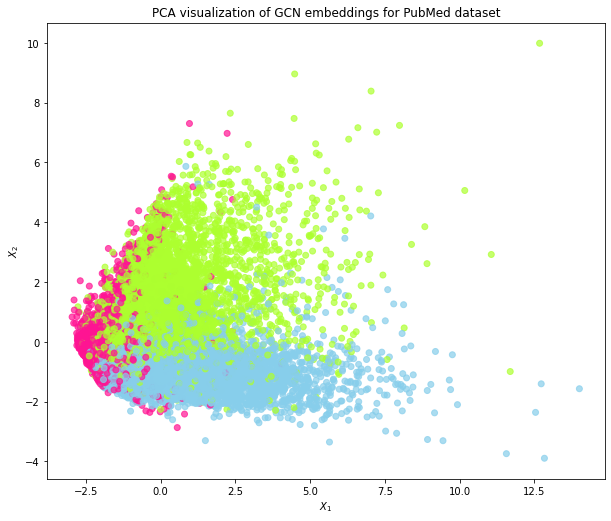

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    c=node_subjects.astype("category").cat.codes,
    cmap=cmap,
    alpha=0.7,
    
)
ax.set(
    aspect="equal",
    xlabel="$X_1$",
    ylabel="$X_2$",
    title=f"{transform.__name__} visualization of GCN embeddings for PubMed dataset",
)

In [ ]:
transform = TSNE  
Y = emb.squeeze(0)
print(Y.shape)
trans = transform(n_components=2)
Y_reduced = trans.fit_transform(Y)
print(Y_reduced.shape)

(19717, 30)
(19717, 2)


[Text(0, 0.5, '$X_2$'),
 Text(0.5, 0, '$X_1$'),
 Text(0.5, 1.0, 'TSNE visualization of GCN embeddings for PubMed dataset'),
 None]

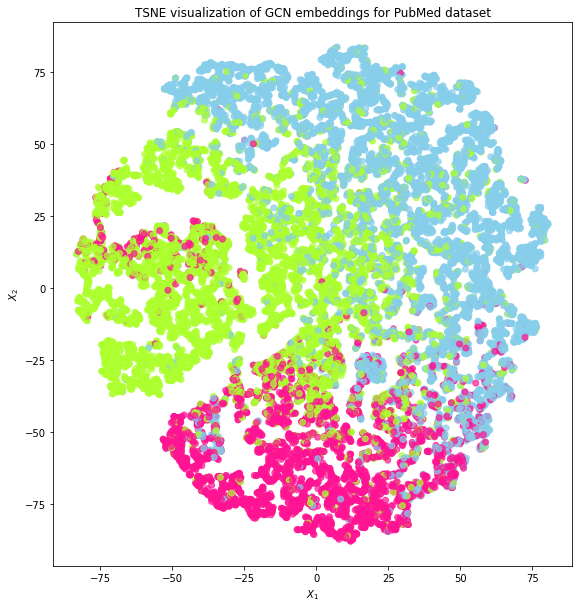

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(
    Y_reduced[:, 0],
    Y_reduced[:, 1],
    c=node_subjects.astype("category").cat.codes,
    cmap=cmap,
    alpha=0.7,
)
ax.set(
    aspect="equal",
    xlabel="$X_1$",
    ylabel="$X_2$",
    title=f"{transform.__name__} visualization of GCN embeddings for PubMed dataset",
)

#CiteSeer Dataset Results

In [ ]:
dataset = sg.datasets.CiteSeer()
display(HTML(dataset.description))
G, node_subjects = dataset.load()

In [ ]:
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 3312, Edges: 4715

 Node types:
  paper: [3312]
    Features: float32 vector, length 3703
    Edge types: paper-cites->paper

 Edge types:
    paper-cites->paper: [4715]
        Weights: all 1 (default)
        Features: none


In [ ]:
print(node_subjects.value_counts().to_frame())

        subject
DB          701
IR          668
Agents      596
ML          590
HCI         508
AI          249


In [ ]:
train_subjects, test_subjects = model_selection.train_test_split(node_subjects,train_size=250, test_size=None, stratify=node_subjects)
val_subjects, test_subjects = model_selection.train_test_split(test_subjects,train_size=750, test_size=None, stratify=test_subjects)
train_subjects.value_counts().to_frame()

,subject
DB,53
IR,50
Agents,45
ML,45
HCI,38
AI,19


In [ ]:
target_encoding = preprocessing.LabelBinarizer()
train_targets = target_encoding.fit_transform(train_subjects)
val_targets = target_encoding.transform(val_subjects)
test_targets = target_encoding.transform(test_subjects)

In [ ]:
generator = FullBatchNodeGenerator(G, method="gcn")
train_gen = generator.flow(train_subjects.index, train_targets)

Using GCN (local pooling) filters...


In [ ]:
train_gen = generator.flow(train_subjects.index, train_targets)

In [ ]:
gcn = GCN(layer_sizes=[30,30], activations=["relu", "relu"], generator=generator, dropout=0.15)

In [ ]:
x_inp, x_out = gcn.in_out_tensors()
print(x_out)

Tensor("gather_indices_3/GatherV2:0", shape=(1, None, 30), dtype=float32)


In [ ]:
predictions = layers.Dense(units=train_targets.shape[1], activation="softmax")(x_out)

In [ ]:
model = Model(inputs=x_inp, outputs=predictions)
model.compile(
    optimizer=optimizers.Adam(lr=0.01),
    loss=losses.categorical_crossentropy,
    metrics=["acc"],
)

In [ ]:
val_gen = generator.flow(val_subjects.index, val_targets)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
es_callback = EarlyStopping(monitor="val_acc", patience=60, restore_best_weights=True)

In [ ]:
history = model.fit(
    train_gen,
    epochs=200,
    validation_data=val_gen,
    verbose=2,
    shuffle=False, 
    callbacks=[es_callback])

Epoch 1/200
1/1 - 0s - loss: 1.7904 - acc: 0.1760 - val_loss: 1.7142 - val_acc: 0.4720
Epoch 2/200
1/1 - 0s - loss: 1.6436 - acc: 0.6280 - val_loss: 1.5823 - val_acc: 0.5267
Epoch 3/200
1/1 - 0s - loss: 1.4207 - acc: 0.7080 - val_loss: 1.4374 - val_acc: 0.5493
Epoch 4/200
1/1 - 0s - loss: 1.1398 - acc: 0.7800 - val_loss: 1.3000 - val_acc: 0.6107
Epoch 5/200
1/1 - 0s - loss: 0.8816 - acc: 0.8320 - val_loss: 1.1767 - val_acc: 0.6640
Epoch 6/200
1/1 - 0s - loss: 0.6537 - acc: 0.8760 - val_loss: 1.0880 - val_acc: 0.6960
Epoch 7/200
1/1 - 0s - loss: 0.4493 - acc: 0.9080 - val_loss: 1.0407 - val_acc: 0.7067
Epoch 8/200
1/1 - 0s - loss: 0.3171 - acc: 0.9240 - val_loss: 1.0321 - val_acc: 0.7093
Epoch 9/200
1/1 - 0s - loss: 0.2113 - acc: 0.9480 - val_loss: 1.0612 - val_acc: 0.7040
Epoch 10/200
1/1 - 0s - loss: 0.1376 - acc: 0.9720 - val_loss: 1.1160 - val_acc: 0.6920
Epoch 11/200
1/1 - 0s - loss: 0.0924 - acc: 0.9840 - val_loss: 1.1664 - val_acc: 0.6880
Epoch 12/200
1/1 - 0s - loss: 0.0741 - ac

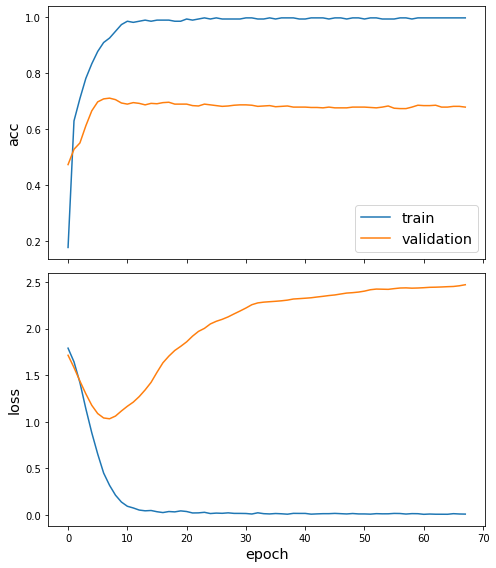

In [ ]:
sg.utils.plot_history(history)

In [ ]:
test_gen = generator.flow(test_subjects.index, test_targets)
test_metrics = model.evaluate(test_gen)
print("\nTest Set Metrics:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

1/1 [==============================] - 0s 1ms/step - loss: 0.9982 - acc: 0.6981

Test Set Metrics:
	loss: 0.9982
	acc: 0.6981


In [ ]:
all_nodes = node_subjects.index
all_gen = generator.flow(all_nodes)
all_predictions = model.predict(all_gen)
node_predictions = target_encoding.inverse_transform(all_predictions.squeeze())

df = pd.DataFrame({"Predicted": node_predictions, "True": node_subjects})
print(df.head(20))
df.to_csv('predicted_true_label_Citeseer.csv')

       Predicted    True
100157       HCI  Agents
100598        IR      IR
105684    Agents  Agents
11099         IR      DB
114091        DB      AI
11510         AI      AI
115971    Agents  Agents
117999        IR      IR
120432        DB      AI
126894    Agents     HCI
128239        IR      IR
130387    Agents  Agents
157253        IR      DB
164846        IR      IR
164953        DB      DB
165504        IR      IR
172324    Agents      DB
17752     Agents      ML
184682    Agents  Agents
186486    Agents  Agents


In [ ]:
embedding_model = Model(inputs=x_inp, outputs=x_out)
emb = embedding_model.predict(all_gen)
print(emb.shape)

(1, 3312, 30)


In [ ]:
transform = PCA  
X = emb.squeeze(0)
print(X.shape)
trans = transform(n_components=2)
X_reduced = trans.fit_transform(X)
print(X_reduced.shape)

(3312, 30)
(3312, 2)


In [ ]:
cmap = matplotlib.colors.ListedColormap(["darkorchid","springgreen","aqua","gold","coral","mediumblue"], name='from_list', N=None)

[Text(0, 0.5, '$X_2$'),
 Text(0.5, 0, '$X_1$'),
 Text(0.5, 1.0, 'TSNE visualization of GCN embeddings for CiteSeer dataset'),
 None]

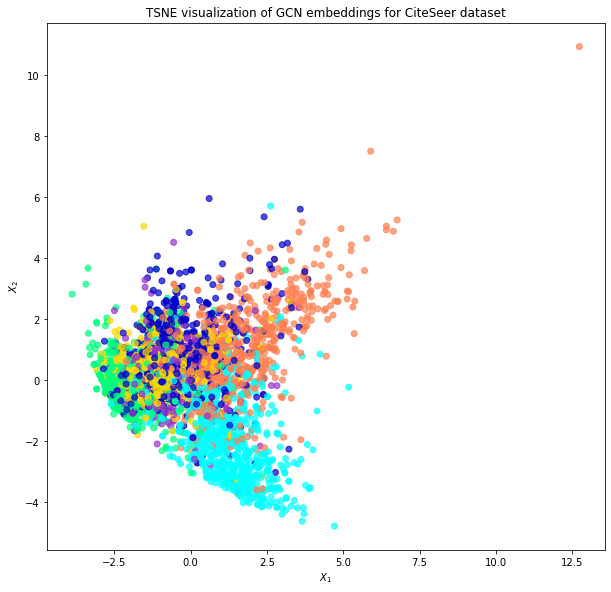

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(
    X_reduced[:, 0],
    X_reduced[:, 1],
    c=node_subjects.astype("category").cat.codes,
    cmap=cmap,
    alpha=0.7,
    
)
ax.set(
    aspect="equal",
    xlabel="$X_1$",
    ylabel="$X_2$",
    title=f"{transform.__name__} visualization of GCN embeddings for CiteSeer dataset",
)

In [ ]:
transform = TSNE  
Y = emb.squeeze(0)
print(Y.shape)
trans = transform(n_components=2)
Y_reduced = trans.fit_transform(Y)
print(Y_reduced.shape)

(3312, 30)
(3312, 2)


[Text(0, 0.5, '$X_2$'),
 Text(0.5, 0, '$X_1$'),
 Text(0.5, 1.0, 'TSNE visualization of GCN embeddings for CiteSeer dataset'),
 None]

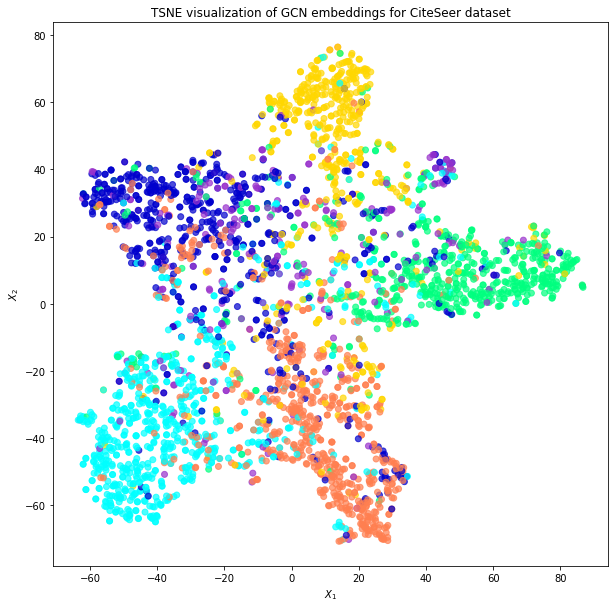

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(
    Y_reduced[:, 0],
    Y_reduced[:, 1],
    c=node_subjects.astype("category").cat.codes,
    cmap=cmap,
    alpha=0.7,
)
ax.set(
    aspect="equal",
    xlabel="$X_1$",
    ylabel="$X_2$",
    title=f"{transform.__name__} visualization of GCN embeddings for CiteSeer dataset",
)